# Red Neuronal

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,targetBooleano,regularizar,reemplazarCategoricas_HashTrick,reemplazarNullsNum

[###] Initial Preprocessings Done                           
[###] Aditional Preprocessings Done                                                   


### Codigo a correr

In [4]:
MAX_ITER = 10**4
MAX_JOBS = -1

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [5]:
runSimple = True
runMlpC = True
runMlpC_R = True
runHt = True

**Save :** Guardar Modelo (pisa anterior)

In [6]:
saveMlpC = True
saveMlpC_R = True
saveHt = True
saveBest = True

In [19]:
predictions = pd.DataFrame()

In [8]:
from utilities import score, score2, df_feat, df_targ, train_val

### Preprocesamiento

In [9]:
targetBooleano(df_targ, inplace=True)
ht_feat = reemplazarCategoricas_HashTrick(df_feat)

reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)

df_feat_r = regularizar(df_feat)

reemplazarNullsNum(ht_feat, inplace=True)
reemplazarFechas(ht_feat , inplace=True)

,horas_de_sol,humedad_tarde,humedad_temprano,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_velocidad,...,missing_rafaga_viento_max_velocidad,missing_temp_max,missing_temp_min,missing_temperatura_tarde,missing_temperatura_temprano,missing_velocidad_viendo_tarde,missing_velocidad_viendo_temprano,y,m,d
id,,,,,,,,,,,,,,,,,,,,,
74816,7.629393,78.0,74.0,5.470542,68.0,4.50597,4.430203,1024.200000,1026.200000,48.0,...,False,False,False,False,False,False,False,2014,6,7
64318,7.629393,14.0,56.0,5.470542,5.8,1.00000,4.430203,998.300000,1002.500000,61.0,...,False,False,False,False,False,False,False,2014,12,7
54357,2.600000,79.0,47.0,5.470542,0.0,8.00000,7.000000,1000.500000,1005.800000,57.0,...,False,False,False,False,False,False,False,2010,7,8
1762,0.000000,92.0,96.0,3.000000,5.0,8.00000,8.000000,1015.400000,1016.800000,54.0,...,False,False,False,False,False,False,False,2015,11,4
89422,7.629393,14.0,37.0,5.470542,0.0,2.00000,4.430203,1006.400000,1011.100000,50.0,...,False,False,False,False,False,False,False,2014,12,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49272,6.500000,63.0,44.0,3.800000,0.4,6.00000,2.000000,1011.800000,1014.500000,72.0,...,False,False,False,False,False,False,False,2012,5,23
13885,2.100000,65.0,80.0,1.600000,5.2,7.00000,7.000000,1017.500000,1016.300000,48.0,...,False,False,False,False,False,False,False,2011,10,25
4586,7.629393,81.0,62.0,5.470542,0.0,4.50597,4.430203,1015.257118,1017.655555,35.0,...,False,False,False,False,False,False,False,2015,12,16


In [10]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ, True )
train_feat_r, val_feat_r, train_targ_r, val_targ_r = train_val( df_feat_r, df_targ, True )
train_feat_ht, val_feat_ht, train_targ_ht, val_targ_ht = train_val( ht_feat, df_targ, True )

In [11]:
layer_sizes = []
for i in range(10):
    for j in range(10):
        layer_sizes.append( ( i+1, j+1 ) )

## Simple

In [12]:
if (runSimple):
    mlp = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    ).fit(train_feat, train_targ)

AUC-ROC: 0.8499260840366799
              precision    recall  f1-score   support

       False       0.85      0.96      0.90      7946
        True       0.74      0.42      0.53      2290

    accuracy                           0.84     10236
   macro avg       0.79      0.69      0.72     10236
weighted avg       0.83      0.84      0.82     10236

CONFUSION MATRIX


None

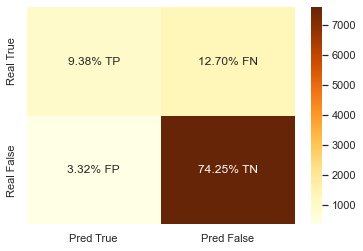

In [13]:
if (runSimple):
    pred = mlp.predict(val_feat)
    prob = mlp.predict_proba(val_feat)
    display(score(val_targ, pred, prob[:,1]))
    pdf = score2('Simple','Basico',val_targ, pred, prob[:,1])
    predictions = predictions.append( pdf )

## MLP Clasifier

In [14]:
if (runMlpC):
    mlp_cls = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    )
    params = {
        'alpha': np.arange(1e-5,10e-5,1e-5),
        'hidden_layer_sizes':layer_sizes,
        'activation': ['identity', 'logistic', 'relu', 'tanh'],
        'learning_rate': ["constant", "invscaling", "adaptive"],
    }
    
    mlp_cls_grid = RandomizedSearchCV(
        mlp_cls,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1,
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveMlpC):
        dump(mlp_cls_grid, 'models/NN/mlp_cls_grid.sk')
else:
    # Cargar
    mlp_cls_grid = load('models/NN/mlp_cls_grid.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [15]:
print(f"Best score: {mlp_cls_grid.best_score_}")
print(f"Best params {mlp_cls_grid.best_params_}")

Best score: 0.8531912253343096
Best params {'learning_rate': 'adaptive', 'hidden_layer_sizes': (6, 6), 'alpha': 9e-05, 'activation': 'identity'}


In [16]:
mlp_cls = mlp_cls_grid.best_estimator_

AUC-ROC: 0.8461262539609613
              precision    recall  f1-score   support

       False       0.87      0.93      0.90      7946
        True       0.67      0.50      0.57      2290

    accuracy                           0.83     10236
   macro avg       0.77      0.72      0.74     10236
weighted avg       0.82      0.83      0.82     10236

CONFUSION MATRIX
CPU times: user 431 ms, sys: 101 ms, total: 531 ms
Wall time: 183 ms


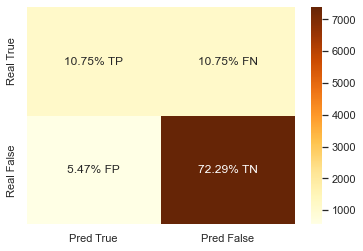

In [20]:
%%time
pred = mlp_cls.predict(val_feat)
prob = mlp_cls.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [21]:
pdf = score2('Val','Basico',val_targ, pred, prob[:,1])
predictions = predictions.append( pdf )

## MPL Clasifier - Features Regularizados

In [22]:
if (runMlpC_R):
    mlp_cls_r = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    )
    params = {
        'alpha': np.arange(1e-5,10e-5,1e-5),
        'hidden_layer_sizes':layer_sizes,
        'activation': ['identity', 'logistic', 'relu', 'tanh'],
        'learning_rate': ["constant", "invscaling", "adaptive"],
    }
    
    mlp_cls_r_grid = RandomizedSearchCV(
        mlp_cls_r,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1,
    ).fit(train_feat_r, train_targ_r)
    
    # Guardar
    if(saveMlpC_R):
        dump(mlp_cls_r_grid, 'models/NN/mlp_cls_r_grid.sk')
        dump(mlp_cls_r_grid.best_estimator_, 'models/NN/mlp_cls_r.sk')
else:
    # Cargar
    mlp_cls_r_grid = load('models/NN/mlp_cls_r_grid.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [23]:
print(f"Best score: {mlp_cls_r_grid.best_score_}")
print(f"Best params {mlp_cls_r_grid.best_params_}")

Best score: 0.868838599178609
Best params {'learning_rate': 'adaptive', 'hidden_layer_sizes': (9, 8), 'alpha': 2e-05, 'activation': 'tanh'}


In [24]:
mlp_cls_r = mlp_cls_r_grid.best_estimator_

AUC-ROC: 0.8644458171258617
              precision    recall  f1-score   support

       False       0.86      0.94      0.90      7946
        True       0.71      0.48      0.57      2290

    accuracy                           0.84     10236
   macro avg       0.79      0.71      0.74     10236
weighted avg       0.83      0.84      0.83     10236

CONFUSION MATRIX
CPU times: user 350 ms, sys: 80.9 ms, total: 431 ms
Wall time: 166 ms


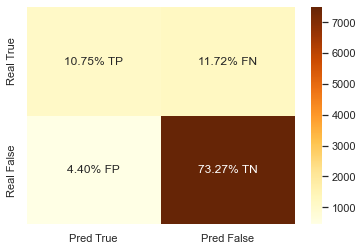

In [25]:
%%time
pred = mlp_cls_r.predict(val_feat_r)
prob = mlp_cls_r.predict_proba(val_feat_r)
score(val_targ_r, pred, prob[:,1])

In [26]:
pdf = score2('Reg','Regularizado',val_targ_r, pred, prob[:,1])
predictions = predictions.append( pdf )

## Hashing Trick

In [27]:
if (runHt):
    mlp_ht = MLPClassifier(
        solver='adam',
        max_iter=MAX_ITER,
        random_state=1,
    )
    params = {
        'alpha': np.arange(1e-5,10e-5,1e-5),
        'hidden_layer_sizes':layer_sizes,
        'activation': ['identity', 'logistic', 'relu', 'tanh'],
        'learning_rate': ["constant", "invscaling", "adaptive"],
    }
    
    mlp_ht_grid = RandomizedSearchCV(
        mlp_ht,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1,
    ).fit(train_feat_ht, train_targ_ht)
    
    # Guardar
    if(saveHt):
        dump(mlp_ht_grid, 'models/NN/mlp_ht_grid.sk')
else:
    # Cargar
    mlp_ht_grid = load('models/NN/mlp_ht_grid.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [28]:
print(f"Best score: {mlp_ht_grid.best_score_}")
print(f"Best params {mlp_ht_grid.best_params_}")

Best score: 0.8661652348060249
Best params {'learning_rate': 'constant', 'hidden_layer_sizes': (6, 2), 'alpha': 6e-05, 'activation': 'identity'}


In [29]:
mlp_ht = mlp_ht_grid.best_estimator_

AUC-ROC: 0.8610972316410882
              precision    recall  f1-score   support

       False       0.86      0.95      0.90      7946
        True       0.71      0.45      0.55      2290

    accuracy                           0.84     10236
   macro avg       0.78      0.70      0.72     10236
weighted avg       0.82      0.84      0.82     10236

CONFUSION MATRIX
CPU times: user 500 ms, sys: 118 ms, total: 618 ms
Wall time: 209 ms


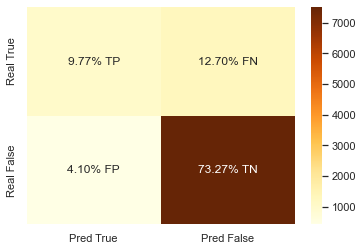

In [30]:
%%time
pred = mlp_ht.predict(val_feat_ht)
prob = mlp_ht.predict_proba(val_feat_ht)
score(val_targ_ht, pred, prob[:,1])

In [31]:
pdf = score2('HT','Hashing Trick',val_targ_ht, pred, prob[:,1])
predictions = predictions.append( pdf )

## Resultados

In [32]:
predictions

,Modelo,Preprocesamientos,Clase,AUC-ROC,Accuracy,Precision,Recall,F1 score,Support
0,Val,Basico,AVG,0.846126,0.833919,0.822833,0.833919,0.824613,10236
1,Val,Basico,True,NaN,NaN,0.673529,0.500000,0.573935,2290
2,Val,Basico,False,NaN,NaN,0.865862,0.930154,0.896857,7946
0,Reg,Regularizado,AVG,0.864446,0.839000,0.827732,0.839000,0.826782,10236
1,Reg,Regularizado,True,NaN,NaN,0.708984,0.475546,0.569263,2290
2,Reg,Regularizado,False,NaN,NaN,0.861954,0.943745,0.900997,7946
0,Reg,Regularizado,AVG,0.861097,0.835287,0.823143,0.835287,0.820969,10236
1,Reg,Regularizado,True,NaN,NaN,0.707989,0.448908,0.549439,2290
2,Reg,Regularizado,False,NaN,NaN,0.856330,0.946640,0.899223,7946
